<a href="https://colab.research.google.com/github/OmarAlsaqa/CMT-Convolutional-Neural-Networks-Meet-Vision-Transformers/blob/main/CMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Jul 23 19:26:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl -q
!pip install pytorch-lightning torchmetrics -q

     |████████████████████████████████| 813 kB 35.2 MB/s 
     |████████████████████████████████| 234 kB 60.5 MB/s 
     |████████████████████████████████| 10.6 MB 59.0 MB/s 
     |████████████████████████████████| 118 kB 64.0 MB/s 
     |████████████████████████████████| 829 kB 54.3 MB/s 
     |████████████████████████████████| 636 kB 46.4 MB/s 
     |████████████████████████████████| 1.3 MB 36.1 MB/s 
     |████████████████████████████████| 294 kB 70.4 MB/s 
     |████████████████████████████████| 142 kB 65.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires tensorboard~=2.5, but you have tensorboard 2.4.1 which is incompatible.


In [ ]:
import os
import numpy as np

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms as T
from tqdm import tqdm
import pytorch_lightning as pl
import torchmetrics

from typing import List, Optional

In [ ]:
class Conv2x2(nn.Module):
    """
    2x2 Convolution
    """
    def __init__(self, in_channels, out_channels, stride = 1):
        super(Conv2x2, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2,
            stride = stride, padding = 0, bias = True
        )

    def forward(self, x):
        result = self.conv(x)
        print('Conv2x2', result.shape)
        if torch.isnan(torch.min(result)):
          print('Conv2x2 is NaN')
        return result

In [ ]:
class DWCONV(nn.Module):
    """
    Depthwise Convolution
    """
    def __init__(self, in_channels, out_channels, stride = 1):
        super(DWCONV, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
            stride = stride, padding = 1, groups = in_channels, bias = True
        )

    def forward(self, x):
        result = self.depthwise(x)
        print('DWCONV', result.shape)
        if torch.isnan(torch.min(result)):
          print('DWCONV is NaN')
        return result

In [ ]:
class LPU(nn.Module):
    """
    Local Perception Unit to extract local infomation.
    LPU(X) = DWConv(X) + X
    """
    def __init__(self, in_channels, out_channels):
        super(LPU, self).__init__()
        self.DWConv = DWCONV(in_channels, out_channels)

    def forward(self, x):
        result = self.DWConv(x) + x
        print('LPU', result.shape)
        if torch.isnan(torch.min(result)):
          print('LPU is NaN')
        return result

In [ ]:
class LMHSA(nn.Module):
    """
    Lightweight Multi-head-self-attention module.
    Inputs:
        Q: [N, C, H, W]
        K: [N, C, H / stride, W / stride]
        V: [N, C, H / stride, W / stride]
    Outputs:
        X: [N, C, H, W]
    """
    def __init__(self, input_size, channels, d_k, d_v, stride, heads, dropout):
        super(LMHSA, self).__init__()
        self.dwconv_k = DWCONV(channels, channels, stride = stride)
        self.dwconv_v = DWCONV(channels, channels, stride = stride)
        self.fc_q = nn.Linear(channels, heads * d_k)
        self.fc_k = nn.Linear(channels, heads * d_k)
        self.fc_v = nn.Linear(channels, heads * d_v)
        self.fc_o = nn.Linear(heads * d_k, channels)

        self.channels = channels
        self.d_k = d_k
        self.d_v = d_v
        self.stride = stride
        self.heads = heads
        self.dropout = dropout
        self.scaled_factor = self.d_k ** -0.5
        self.num_patches = (self.d_k // self.stride) ** 2
        self.B = nn.Parameter(torch.Tensor(1, self.heads, input_size ** 2, (input_size // stride) ** 2), requires_grad = True)


    def forward(self, x):
        b, c, h, w = x.shape

        # Reshape
        x_reshape = x.view(b, c, h * w).permute(0, 2, 1)
        # x_reshape = nn.LayerNorm(c).cuda()(x_reshape)
        x_reshape = torch.nn.functional.layer_norm(x_reshape, (b, h * w, c))

        # Get q, k, v
        q = self.fc_q(x_reshape)
        q = q.view(b, h * w, self.heads, self.d_k).permute(0, 2, 1, 3).contiguous()  # [b, heads, h * w, d_k]

        k = self.dwconv_k(x)
        k_b, k_c, k_h, k_w = k.shape
        k = k.view(k_b, k_c, k_h * k_w).permute(0, 2, 1).contiguous()
        k = self.fc_k(k)
        k = k.view(k_b, k_h * k_w, self.heads, self.d_k).permute(0, 2, 1, 3).contiguous()  # [b, heads, k_h * k_w, d_k]

        v = self.dwconv_v(x)
        v_b, v_c, v_h, v_w = v.shape
        v = v.view(v_b, v_c, v_h * v_w).permute(0, 2, 1).contiguous()
        v = self.fc_v(v)
        v = v.view(v_b, v_h * v_w, self.heads, self.d_v).permute(0, 2, 1, 3).contiguous() # [b, heads, v_h * v_w, d_v]

        # Attention
        attn = torch.einsum('... i d, ... j d -> ... i j', q, k) * self.scaled_factor
        attn = attn + self.B
        attn = torch.softmax(attn, dim = -1) # [b, heads, h * w, k_h * k_w]

        result = torch.matmul(attn, v).permute(0, 2, 1, 3)
        result = result.contiguous().view(b, h * w, self.heads * self.d_v)
        result = self.fc_o(result).view(b, self.channels, h, w)
        result = result + x
        print('LMHSA', result.shape)
        if torch.isnan(torch.min(result)):
          print('LMHSA is NaN')
        return result

In [ ]:
class IRFFN(nn.Module):
    """
    Inverted Residual Feed-forward Network
    """
    def __init__(self, in_channels, R):
        super(IRFFN, self).__init__()
        exp_channels = int(in_channels * R)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, exp_channels, kernel_size = 1),
            nn.BatchNorm2d(exp_channels),
            nn.GELU()
        )

        self.dwconv = nn.Sequential(
            DWCONV(exp_channels, exp_channels),
            nn.BatchNorm2d(exp_channels),
            nn.GELU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(exp_channels, in_channels, 1),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        result = x + self.conv2(self.dwconv(self.conv1(x)))
        print('IRFFN', result.shape)
        if torch.isnan(torch.min(result)):
          print('IRFFN is NaN')
        return result

In [ ]:
class Patch_Aggregate(nn.Module):
    """
    Aggregate the patches into a single image.
    To produce the hierachical representation.
    Applied before each stage to reduce the size of intermediate features
    (2x downsampling of resolution), and project it to a larger dimension
    (2x enlargement of dimension).
    Input:
        - x: (B, In_C, H, W)
    Output:
        - x: (B, Out_C, H / 2, W / 2)
    """
    def __init__(self, in_channels, out_channels = None):
        super(Patch_Aggregate, self).__init__()
        if out_channels is None:
            out_channels = in_channels
        self.conv = Conv2x2(in_channels, out_channels, stride = 2)

    def forward(self, x):
        x = self.conv(x)
        _, c, h, w = x.size()
        # result = nn.LayerNorm((c, h, w)).cuda()(x)
        result = torch.nn.functional.layer_norm(x, (c, h, w))
        print('Patch_Aggregate', result.shape)
        if torch.isnan(torch.min(result)):
          print('Patch_Aggregate is NaN')
        return result

In [ ]:
class CMTStem(nn.Module):
    """
    Use CMTStem module to process input image and overcome the limitation of the
    non-overlapping patches.
    First past through the image with a 2x2 convolution to reduce the image size.
    Then past throught two 1x1 convolution for better local information.
    Input:
        - x: (B, 3, H, W)
    Output:
        - result: (B, 32, H / 2, W / 2)
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1, bias = False)
        self.gelu1 = nn.GELU()
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.gelu2 = nn.GELU()
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.gelu3 = nn.GELU()
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        print('Before', x.shape)
        x = self.conv1(x)
        x = self.gelu1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.gelu2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.gelu3(x)
        result = self.bn3(x)
        print('CMTStem', result.shape)
        # print(result)
        if torch.isnan(torch.min(result)):
          print('CMTStem is NaN')
        return result

In [ ]:
class CMTBlock(nn.Module):
  def __init__(self, img_size, stride, d_k, d_v, num_heads, R = 3.6, in_channels = 46):
      super(CMTBlock, self).__init__()

      # Local Perception Unit
      self.lpu = LPU(in_channels, in_channels)

      # Lightweight MHSA
      self.lmhsa = LMHSA(img_size, in_channels, d_k, d_v, stride, num_heads, 0.0)

      # Inverted Residual FFN
      self.irffn = IRFFN(in_channels, R)

  def forward(self, x):
      x = self.lpu(x)
      x = self.lmhsa(x)
      x = self.irffn(x)
      print('CMTBlock', x.shape)
      if torch.isnan(torch.min(x)):
          print('CMTBlock is NaN')
      return x

In [ ]:
class CMT(nn.Module):
  def __init__(self,
      in_channels = 3,
      stem_channel = 32,
      cmt_channel = [46, 92, 184, 368],
      patch_channel = [46, 92, 184, 368],
      block_layer = [2, 2, 10, 2],
      R = 3.6,
      img_size = 224,
      num_class = 10
  ):
      super(CMT, self).__init__()

      # Image size for each stage
      size = [img_size // 4, img_size // 8, img_size // 16, img_size // 32]

      # Stem layer
      self.stem = CMTStem(in_channels, stem_channel)

      # Patch Aggregation Layer
      self.patch1 = Patch_Aggregate(stem_channel, patch_channel[0])
      self.patch2 = Patch_Aggregate(patch_channel[0], patch_channel[1])
      self.patch3 = Patch_Aggregate(patch_channel[1], patch_channel[2])
      self.patch4 = Patch_Aggregate(patch_channel[2], patch_channel[3])

      # CMT Block Layer
      stage1 = []
      for _ in range(block_layer[0]):
          cmt_layer = CMTBlock(
                  img_size = size[0],
                  stride = 8,
                  d_k = cmt_channel[0],
                  d_v = cmt_channel[0],
                  num_heads = 1,
                  R = R,
                  in_channels = patch_channel[0]
          )
          stage1.append(cmt_layer)
      self.stage1 = nn.Sequential(*stage1)

      stage2 = []
      for _ in range(block_layer[1]):
          cmt_layer = CMTBlock(
                  img_size = size[1],
              stride = 4,
              d_k = cmt_channel[1] // 2,
              d_v = cmt_channel[1] // 2,
              num_heads = 2,
              R = R,
              in_channels = patch_channel[1]
          )
          stage2.append(cmt_layer)
      self.stage2 = nn.Sequential(*stage2)

      stage3 = []
      for _ in range(block_layer[2]):
          cmt_layer = CMTBlock(
              img_size = size[2],
              stride = 2,
              d_k = cmt_channel[2] // 4,
              d_v = cmt_channel[2] // 4,
              num_heads = 4,
              R = R,
              in_channels = patch_channel[2]
          )
          stage3.append(cmt_layer)
      self.stage3 = nn.Sequential(*stage3)

      stage4 = []
      for _ in range(block_layer[3]):
          cmt_layer = CMTBlock(
              img_size = size[3],
              stride = 1,
              d_k = cmt_channel[3] // 8,
              d_v = cmt_channel[3] // 8,
              num_heads = 8,
              R = R,
              in_channels = patch_channel[3]
          )
          stage4.append(cmt_layer)
      self.stage4 = nn.Sequential(*stage4)

      # Global Average Pooling
      self.avg_pool = nn.AdaptiveAvgPool2d(1)

      # FC
      self.fc = nn.Sequential(
          nn.Linear(cmt_channel[3], 1280),
          nn.ReLU(inplace = True),
      )

      # Final Classifier
      self.classifier = nn.Linear(1280, num_class)


  def forward(self, x):
      x = self.stem(x)

      x = self.patch1(x)
      x = self.stage1(x)

      x = self.patch2(x)
      x = self.stage2(x)

      x = self.patch3(x)
      x = self.stage3(x)

      x = self.patch4(x)
      x = self.stage4(x)

      x = self.avg_pool(x)
      x = torch.flatten(x, 1)

      x = self.fc(x)
      logit = self.classifier(x)  
      print('CMT', logit.shape) 
      if torch.isnan(torch.min(logit)):
          print('CMT is NaN')
      return logit

In [ ]:
def CMT_Ti(img_size = 224, num_class = 1000):
    model = CMT(
        in_channels = 3,
        stem_channel = 16,
        cmt_channel = [46, 92, 184, 368],
        patch_channel = [46, 92, 184, 368],
        block_layer = [2, 2, 10, 2],
        R = 3.6,
        img_size = img_size,
        num_class = num_class
    )
    return model

def CMT_XS(img_size = 224, num_class = 1000):
    model = CMT(
        in_channels = 3,
        stem_channel = 16,
        cmt_channel = [52, 104, 208, 416],
        patch_channel = [52, 104, 208, 416],
        block_layer = [3, 3, 12, 3],
        R = 3.8,
        img_size = img_size,
        num_class = num_class
    )
    return model

def CMT_S(img_size = 224, num_class = 1000):
    model = CMT(
        in_channels = 3,
        stem_channel = 32,
        cmt_channel = [64, 128, 256, 512],
        patch_channel = [64, 128, 256, 512],
        block_layer = [3, 3, 16, 3],
        R = 4,
        img_size = img_size,
        num_class = num_class
    )
    return model

def CMT_B(img_size = 224, num_class = 1000):
    model = CMT(
        in_channels = 3,
        stem_channel = 38,
        cmt_channel = [76, 152, 304, 608],
        patch_channel = [76, 152, 304, 608],
        block_layer = [4, 4, 20, 4],
        R = 4,
        img_size = img_size,
        num_class = num_class
    )
    return model

In [ ]:
num_class = 1000
def test():
    calc_param = lambda net: sum(p.numel() for p in net.parameters() if p.requires_grad)
    img = torch.rand(2, 3, 224, 224)
    cmt_ti = CMT_Ti(num_class=num_class)
    cmt_xs = CMT_XS(num_class=num_class)
    cmt_x = CMT_S(num_class=num_class)
    cmt_b = CMT_B(num_class=num_class)
    logit = cmt_xs(img)
    print(logit.size())
    print(f"CMT_Ti param: {calc_param(cmt_ti) / 1e6 : .2f} M")
    print(f"CMT_XS param: {calc_param(cmt_xs) / 1e6 : .2f} M")
    print(f"CMT_S  param: {calc_param(cmt_x) / 1e6 : .2f} M")
    print(f"CMT_B  param: {calc_param(cmt_b) / 1e6 : .2f} M")

In [ ]:
test()

Before torch.Size([2, 3, 224, 224])
CMTStem torch.Size([2, 16, 112, 112])
Conv2x2 torch.Size([2, 52, 56, 56])
Patch_Aggregate torch.Size([2, 52, 56, 56])
DWCONV torch.Size([2, 52, 56, 56])
LPU torch.Size([2, 52, 56, 56])
DWCONV torch.Size([2, 52, 7, 7])
DWCONV torch.Size([2, 52, 7, 7])
LMHSA torch.Size([2, 52, 56, 56])
DWCONV torch.Size([2, 197, 56, 56])
IRFFN torch.Size([2, 52, 56, 56])
CMTBlock torch.Size([2, 52, 56, 56])
DWCONV torch.Size([2, 52, 56, 56])
LPU torch.Size([2, 52, 56, 56])
DWCONV torch.Size([2, 52, 7, 7])
DWCONV torch.Size([2, 52, 7, 7])
LMHSA torch.Size([2, 52, 56, 56])
DWCONV torch.Size([2, 197, 56, 56])
IRFFN torch.Size([2, 52, 56, 56])
CMTBlock torch.Size([2, 52, 56, 56])
DWCONV torch.Size([2, 52, 56, 56])
LPU torch.Size([2, 52, 56, 56])
DWCONV torch.Size([2, 52, 7, 7])
DWCONV torch.Size([2, 52, 7, 7])
LMHSA torch.Size([2, 52, 56, 56])
DWCONV torch.Size([2, 197, 56, 56])
IRFFN torch.Size([2, 52, 56, 56])
CMTBlock torch.Size([2, 52, 56, 56])
Conv2x2 torch.Size([2, 1

In [ ]:
def get_cifar10_dataset(train_transform = None, test_transform = None):
    train_dataset = datasets.CIFAR10(
        root = '/content/drive/MyDrive/CMT/data',
        train = True,
        transform = train_transform,
        download = True
    )
    test_dataset = datasets.CIFAR10(
        root = '/content/drive/MyDrive/CMT/data',
        train = False,
        transform = test_transform,
        download = True
    )
    return train_dataset, test_dataset

In [ ]:
# import torch_xla.core.xla_model as xm

use_tpu = os.environ.get('TPU_NAME', None)

def get_dataloader(
        train_transform,
        test_transform,
        img_size = 224,
        split = (0.8, 0.2),
        batch_size = 64,
        num_workers = 2
    ):
    assert len(split) == 2
    assert sum(split) == 1
    assert split[0] + split[1] == 1

    train_dataset, test_dataset = get_cifar10_dataset(train_transform, test_transform)
    train_size = int(len(train_dataset) * split[0])
    test_size = int(len(train_dataset) * split[1])
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset,
        (train_size, test_size)
    )

    # required for TPU support
    samplerXM = None
    if use_tpu:
      samplerXM = torch.utils.data.distributed.DistributedSampler(
          train_dataset,
          num_replicas=xm.xrt_world_size(),
          rank=xm.get_ordinal(),
          shuffle=True
      )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = batch_size,
        # shuffle = True,
        num_workers = num_workers,
        pin_memory = True,
        drop_last = True,
        sampler = samplerXM
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size = batch_size,
        # shuffle = False,
        num_workers = num_workers,
        pin_memory = True,
        drop_last = False,
        sampler = samplerXM
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size = batch_size,
        # shuffle = False,
        num_workers = num_workers,
        pin_memory = True,
        drop_last = False,
        sampler = samplerXM
    )
    return train_loader, val_loader, test_loader

In [ ]:
train_transform = T.Compose([
    # T.RandomCrop(32, padding = 4),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.Resize(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
# Load data
train_loader, val_loader, test_loader = get_dataloader(
    train_transform,
    test_transform,
    img_size = 224,
    split = (0.8, 0.2),
    batch_size = 64,
    num_workers = 2
)


Extracting /content/drive/MyDrive/CMT/data/cifar-10-python.tar.gz to /content/drive/MyDrive/CMT/data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2.6051) tensor(-2.1179)


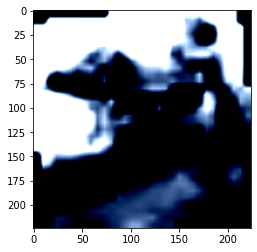

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.7511) tensor(-2.1179)


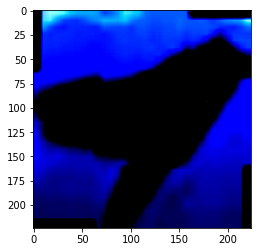

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2.3786) tensor(-2.1179)


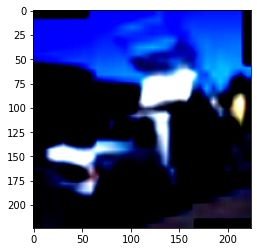

In [ ]:
import matplotlib.pyplot as plt
C = 0
Stop = 3
for batch_idx, (inputs, labels) in enumerate(train_loader):
  print(inputs[0].max(),inputs[0].min())
  plt.figure()
  plt.imshow(inputs[0].permute(1, 2, 0).numpy())
  plt.show()
  C+=1
  if C == Stop:
    break

In [ ]:
# Set device
if use_tpu:
  device = xm.xla_device()
else:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
batch_size = 64
epochs = 150
num_class = 10
lr = 6e-5
weight_decay = 1e-5
model_path = "/content/drive/MyDrive/CMT/weights"

criterion = nn.CrossEntropyLoss()

In [ ]:
# Create model
net = CMT_XS(img_size = 224, num_class = num_class)

In [ ]:
class Base(pl.LightningModule):
  def __init__(self, model, criterion = criterion, lr = lr, batch_size = batch_size, num_classes = num_class, weight_decay = weight_decay, lr_step_size=20, lr_gamma=0.5):
    super(Base, self).__init__()
    self.num_classes = num_classes
    self.lr_step_size = lr_step_size
    self.lr_gamma = lr_gamma
    self.model = model
    self.loss_fn = criterion
    self.lr = lr
    self.batch_size = batch_size
    self.weight_decay = weight_decay

    #top 1 acc
    self.train_acc_top1 = torchmetrics.Accuracy()
    self.val_acc_top1 = torchmetrics.Accuracy()
    self.test_acc_top1 = torchmetrics.Accuracy()

    #top 5 acc
    self.train_acc_top5 = torchmetrics.Accuracy(top_k= 5)
    self.val_acc_top5 = torchmetrics.Accuracy(top_k= 5)
    self.test_acc_top5 = torchmetrics.Accuracy(top_k= 5)

  def forward(self, x):
    logits = self.model(x)
    return logits

  def training_step(self, batch, batch_index):
      x, y = batch
      # y = y.squeeze()
      logits = self(x)
      loss = self.loss_fn(logits, y)
      self.log("train_loss", loss)
      preds = logits.softmax(dim=-1)
      self.train_acc_top1(preds, y)
      self.train_acc_top5(preds, y)
      self.log("train_acc_top1", self.train_acc_top1, on_step= False, on_epoch=True, prog_bar= True)
      self.log("train_acc_top5", self.train_acc_top5, on_step= False, on_epoch=True, prog_bar= True)
      return {'loss' : loss}

  def validation_step(self, batch, batch_index):
      x, y = batch
      # y = y.squeeze()
      logits = self(x)
      preds = logits.softmax(dim=-1)
      loss = self.loss_fn(logits, y)
      self.log("val_loss", loss, prog_bar=True)
      self.val_acc_top1(preds, y)
      self.log('val_acc_top1', self.val_acc_top1, on_step= False, on_epoch = True, prog_bar= True)
      self.val_acc_top5(preds, y)
      self.log('val_acc_top5', self.val_acc_top5, on_step= False, on_epoch = True, prog_bar= True)

  def test_step(self, batch, batch_index):
    x, y = batch
    # y = y.squeeze()
    logits = self(x)
    preds = logits.softmax(dim=-1)
    loss = self.loss_fn(logits, y)
    self.log("test_loss", loss, prog_bar=True)
    self.test_acc_top1(preds, y)
    self.log('test_acc_top1', self.test_acc_top1, on_step= False, on_epoch = True, prog_bar= True)
    self.test_acc_top5(preds, y)
    self.log('test_acc_top5', self.test_acc_top5, on_step= False, on_epoch = True, prog_bar= True)

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr = self.lr, weight_decay = self.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, verbose=True)
    # torch.optim.lr_scheduler.StepLR(optimizer, step_size = self.lr_step_size, gamma=self.lr_gamma, verbose= True)
    return {'optimizer' : optimizer, 'lr_scheduler' : scheduler}

In [ ]:
trainer = pl.Trainer(checkpoint_callback=False, max_epochs=1, overfit_batches=2, gpus=1, progress_bar_refresh_rate=25)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
model = Base(net)

In [ ]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | CMT              | 15.1 M
1 | loss_fn        | CrossEntropyLoss | 0     
2 | train_acc_top1 | Accuracy         | 0     
3 | val_acc_top1   | Accuracy         | 0     
4 | test_acc_top1  | Accuracy         | 0     
5 | train_acc_top5 | Accuracy         | 0     
6 | val_acc_top5   | Accuracy         | 0     
7 | test_acc_top5  | Accuracy         | 0     
----------------------------------------------------
15.1 M    Trainable params
0         Non-trainable params
15.1 M    Total params
60.507    Total estimated model params size (MB)


Adjusting learning rate of group 0 to 6.0000e-05.


Streaming output truncated to the last 5000 lines.
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan

KeyboardInterrupt: ignored

In [ ]:
print(model.model.stem.conv1.weight)

Parameter containing:
tensor([[[[ 0.2718,  0.1394,  0.0676],
          [-0.4111, -0.1200, -0.3837],
          [-0.2274, -0.0826, -0.2532]],

         [[ 0.1310, -0.1398,  0.2311],
          [-0.1970, -0.3126, -0.3970],
          [-0.6158, -0.1500,  0.3080]],

         [[-0.1386,  0.1476,  0.1990],
          [ 0.0446,  0.2142,  0.1339],
          [-0.3380,  0.2188,  0.6858]]],


        [[[-0.1837,  0.3295, -0.6769],
          [-0.1588,  0.3392, -0.2920],
          [ 0.0434,  0.2843, -0.0720]],

         [[ 0.1705, -0.3403,  0.4418],
          [-0.2619, -0.3211,  0.1202],
          [ 0.1055, -0.4312,  0.1072]],

         [[-0.1754,  0.3055,  1.0160],
          [ 0.3852, -0.1883, -0.0456],
          [ 0.2546,  0.3837,  0.2909]]],


        [[[ 0.4036, -0.4083, -0.1194],
          [ 0.0935,  0.0873,  0.1636],
          [-0.2751, -0.1671,  0.0767]],

         [[ 0.4605,  0.0479,  0.4036],
          [-0.4812,  0.1818, -0.1471],
          [-0.4707, -0.1382,  0.1346]],

         [[-0.1522,  0

In [ ]:
model

Base(
  (model): CMT(
    (stem): CMTStem(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (gelu1): GELU()
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (gelu2): GELU()
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (gelu3): GELU()
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (patch1): Patch_Aggregate(
      (conv): Conv2x2(
        (conv): Conv2d(16, 52, kernel_size=(2, 2), stride=(2, 2))
      )
    )
    (patch2): Patch_Aggregate(
      (conv): Conv2x2(
        (conv): Conv2d(52, 104, kernel_size=(2, 2), stride=(2, 2))
      )
    )
    (patch3): Patch_Aggregate(
      (conv): Conv2x2(
     